<!-- PELICAN_BEGIN_SUMMARY -->

Python is quick and easy to code, but can be slow when doing intensive numerical operations. Translating code to Cython can be helpful, but in most cases requires a bit of trial and error to achieve the optimal result. [Cython's tutorials](http://cython.readthedocs.io/en/latest/src/tutorial/) contain a lot of information, but for iterative workflows like optimization with Cython, it's often useful to see it done "live".

For that reason, I decided to record some screencasts showing this iterative optimization process, using an  [Ising Model](https://en.wikipedia.org/wiki/Ising_model), as an example application.

<!-- PELICAN_END_SUMMARY -->

## When to use Cython

Before I get to the videos, I wanted to say a few words about *when* and *why* you might choose Cython.

With scientific Python code, before turning to Cython I'd suggest going as far as you can with *vectorization*.
Vectorization involves the judicious use of built-in routines in NumPy, SciPy, Pandas, and other libraries to reduce the number of explicit for-loops in your code. It can work quite well in many situations, and doesn't require any sort of special compilation step in running your code. See my PyCon 2015 talk, [Losing Your Loops](https://www.youtube.com/watch?v=EEUXKG97YRw) for an intro to this approach.

When a problem cannot be easily solved using standard vectorization approaches, Cython is a good choice.
Cython provides a bridge between Python and C code, and is quite mature and reliable: it forms the basis of much of the PyData/Scientific Python ecosystem (for example, Cython is used heavily in NumPy, SciPy, Pandas, Scikit-Learn, and many other packages).

Other approaches to optimizing Python code are available, but I tend not to use them as often as Cython:

The [PyPy](https://pypy.org/) project is an alternative implementation of Python that avoids the slow loops of the default CPython implementation. Although it is quite promising, it currently does not support many of the core scientific packages, so is not the best choice for scientific code (though that has been changing).

[Numba](http://numba.pydata.org/) is a Python-to-LLVM converter which can often give you 100x speedups in Python by adding a simple compilation decorator to Python functions. For an example of Numba being used on code like that in this notebook, see [Matthew Rocklin's post](http://matthewrocklin.com/blog/work/2015/02/28/Ising). Though it is convenient, Numba doesn't support all Python constructs yet, and can be difficult to optimize when the most straightforward approach fails.

## Videos

Finally, here are the demos of using Cython to optimize an Ising model.

In [1]:
from IPython.display import YouTubeVideo

### Part 1

In part 1, I write a function to evolve an Ising model in Python, along with some tools to visualize the resulting evolution:

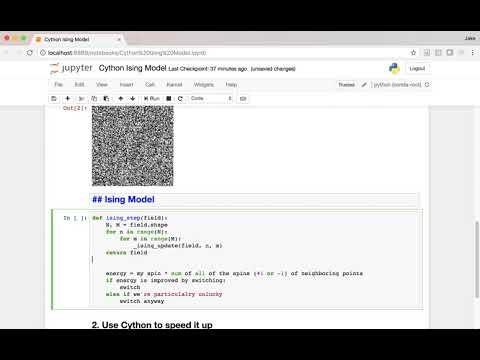

In [2]:
YouTubeVideo('rN7g4gzO2sk', width=600, height=350)

### Part 2

In part 2, I go through the process of optimizing this function with Cython:

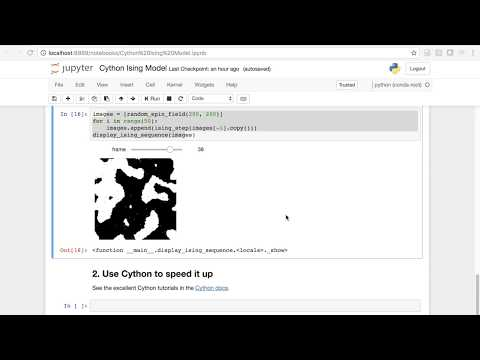

In [3]:
YouTubeVideo('LOzcSuw3yOY', width=600, height=350)

## The Code

Below you can find the code that I wrote in those two videos:

### 1. Simple Python Ising Model

#### Displaying an Ising Field

In [1]:
import numpy as np
from PIL import Image

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255))  # 0 ... 255

In [2]:
random_spin_field(10, 10) # We've created a matrix with 10x10 spaces with the state of the site

array([[ 1, -1, -1, -1, -1,  1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  1,  1],
       [-1, -1,  1, -1, -1,  1,  1, -1, -1,  1],
       [ 1,  1, -1,  1, -1,  1, -1,  1,  1, -1],
       [ 1, -1, -1, -1, -1, -1,  1,  1, -1, -1],
       [-1, -1, -1,  1, -1, -1,  1, -1, -1, -1],
       [-1, -1,  1,  1,  1, -1, -1,  1, -1,  1],
       [-1,  1, -1,  1, -1, -1,  1, -1,  1, -1],
       [-1,  1,  1,  1, -1, -1,  1, -1,  1,  1],
       [-1, -1,  1,  1, -1, -1,  1, -1, -1, -1]])

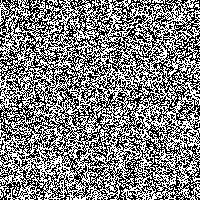

In [3]:
# Now we can use pillow to visualize and create the matrix state directly
# You can use seaborn heatmap to visualize or even imshow from matplotlib

display_spin_field(random_spin_field(200, 200))

#### Implementing the Ising Model

In [14]:
class isingModel:
    import numpy as np
    from PIL import Image
    
    def __init__(self, N, M):
        self.N = N
        self.M = M
        self.field = np.random.choice([-1, 1], size=(self.N, self.M))

    def display_spin_field(self):
        return Image.fromarray(np.uint8((self.field + 1) * 0.5 * 255))

    def ising_step(self, field, beta=0.4):
        N, M = self.field.shape
        for n_offset in range(2):
            for m_offset in range(2):
                for n in range(n_offset, N, 2):
                    for m in range(m_offset, M, 2):
                        _ising_update(self.field, n, m, beta)
        return self.field

    def _ising_update(self, field, n, m, beta):
        total = 0
        N, M = self.field.shape
        for i in range(n-1, n+2):
            for j in range(m-1, m+2):
                if i == n and j == m:
                    continue
                total += self.field[i % N, j % M]
        dE = 2 * self.field[n, m] * total
        if dE <= 0:
            self.field[n, m] *= -1
        elif np.exp(-dE * beta) > np.random.rand():
            self.field[n, m] *= -1

In [15]:
lattice = isingModel(200,200)

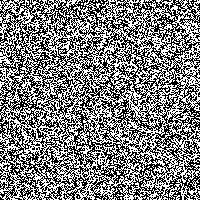

In [16]:
lattice.display_spin_field()

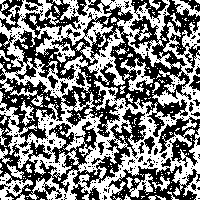

In [5]:
display_spin_field(ising_step(random_spin_field(200, 200)))

#### Animating an Ising Sequence

Note that this requires a live kernel, and so will not show up on the blog or other static rendering:

In [6]:
from ipywidgets import interact

def display_ising_sequence(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])
    return interact(_show)

In [7]:
images = [random_spin_field(200, 200)]
for i in range(500):
    images.append(ising_step(images[-1].copy()))
display_ising_sequence(images);

interactive(children=(IntSlider(value=250, description='frame', max=500), Output()), _dom_classes=('widget-int…